Paso 1: Archivo 'accesos_agrupados.csv' cargado.
Paso 2: Columna de fecha procesada y establecida como índice.
Paso 3: Ingeniería de características completada.
Paso 4: Realizando Aumento de Datos...
   -> Tamaño final del set de entrenamiento: 139 muestras.
Paso 5: Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\tcidm\AppData\Local\Temp\ipykernel_17940\718175097.py:104: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train_final = pd.concat(y_train_aug)


   -> Mejores parámetros encontrados: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 700, 'subsample': 0.8}
Paso 6: Entrenando modelo final y evaluando...

RESULTADOS EN CONJUNTO DE PRUEBA:
   -> MSE (Error Cuadrático Medio): 765694.65
   -> MAE (Error Absoluto Medio): 657.72
   -> RMSE (Raíz del Error Cuadrático Medio): 875.04
   -> R² (Coeficiente de Determinación): 0.38
   -> SMAPE (Error Porcentual Absoluto Simétrico): 39.98%
Paso 7: Generando visualización de resultados...


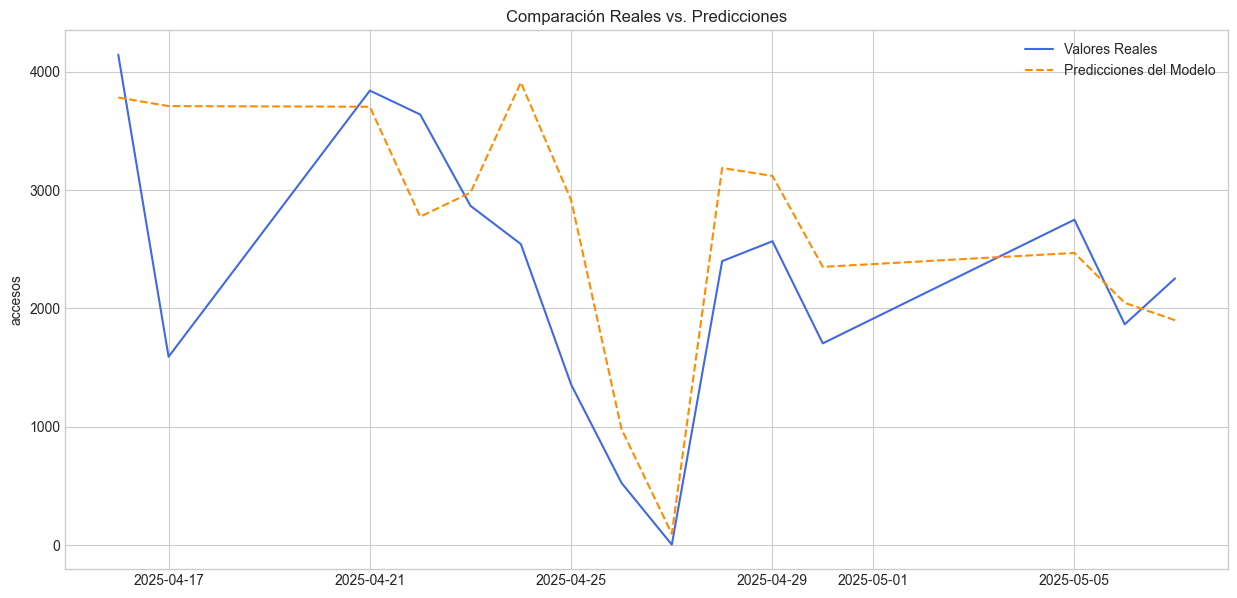

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

# --- 1. Carga y Preparación ---
# Se utilizan los nombres de columna confirmados por ti.
try:
    datos = pd.read_csv('accesos_agrupados.csv', sep=',')
    print("Paso 1: Archivo 'accesos_agrupados.csv' cargado.")
except FileNotFoundError:
    print("Error: No se encontró el archivo.")
    exit()

# Usamos 'Fecha Completa' y la renombramos a 'Fecha' para estandarizar
try:
    datos = datos.rename(columns={'Fecha Completa': 'Fecha'})
    datos['Fecha'] = pd.to_datetime(datos['Fecha'])
    datos = datos.set_index('Fecha').sort_index()
    print("Paso 2: Columna de fecha procesada y establecida como índice.")
except KeyError:
    print("Error: No se encontró la columna 'Fecha Completa'. Columnas detectadas:", datos.columns)
    exit()

# --- 2. Ingeniería de Características ---

# --- ! CORRECCIÓN IMPORTANTE ! ---
# La columna objetivo ahora es 'accesos'.
TARGET = 'Accesos'

# Excluimos columnas de texto y las que no queremos usar directamente.
COLUMNAS_A_EXCLUIR_DE_FEATURES = [TARGET, 'Día de la Semana']

# Usamos 'Número Semestre' para crear las variables dummy.
try:
    datos = pd.get_dummies(datos, columns=['Número Semestre'], prefix='Semestre', drop_first=True)
except KeyError:
    print("Error: No se encontró la columna 'Número Semestre'. Revisa los nombres de columna:")
    print(datos.columns)
    exit()

# Verificamos que la columna TARGET ('accesos') exista antes de continuar.
if TARGET not in datos.columns:
    print(f"Error Crítico: La columna objetivo '{TARGET}' no se encuentra en el dataset.")
    print("Columnas disponibles:", datos.columns)
    exit()

# Ingeniería de características de lags y rolling
for lag in [7, 14, 30, 90, 180]:
    datos[f'lag_{lag}_dias'] = datos[TARGET].shift(lag)
for window in [7, 30, 90]:
    datos[f'media_movil_{window}d'] = datos[TARGET].shift(1).rolling(window=window).mean()
datos['ewma_30d'] = datos[TARGET].shift(1).ewm(span=30, adjust=False).mean()

# Creamos las características cíclicas directamente del índice de fecha.
datos['mes_sin'] = np.sin(2 * np.pi * datos.index.month / 12)
datos['mes_cos'] = np.cos(2 * np.pi * datos.index.month / 12)
datos['dia_semana_sin'] = np.sin(2 * np.pi * datos.index.dayofweek / 7)
datos['dia_semana_cos'] = np.cos(2 * np.pi * datos.index.dayofweek / 7)

datos = datos.dropna()
print("Paso 3: Ingeniería de características completada.")

# --- 3. División de Datos ---
FEATURES = [col for col in datos.columns if col not in COLUMNAS_A_EXCLUIR_DE_FEATURES]
X = datos[FEATURES]
y = datos[TARGET]
test_percentage = 0.10
test_size = int(len(datos) * test_percentage)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# --- 4. DATA AUGMENTATION ---
print("Paso 4: Realizando Aumento de Datos...")
X_train_aug = [X_train.copy()]
y_train_aug = [y_train.copy()]
N_AUGMENTATIONS = 4
for i in range(N_AUGMENTATIONS):
    X_new = X_train.copy()
    if i % 2 == 0:
        y_new = y_train * np.random.uniform(0.95, 1.05)
    else:
        y_new = y_train + np.random.normal(0, y_train.std() * 0.02, len(y_train))
    df_new = X_new.copy()
    df_new[TARGET] = y_new
    for lag in [7, 14, 30, 90, 180]:
        df_new[f'lag_{lag}_dias'] = df_new[TARGET].shift(lag)
    for window in [7, 30, 90]:
        df_new[f'media_movil_{window}d'] = df_new[TARGET].shift(1).rolling(window=window).mean()
    df_new['ewma_30d'] = df_new[TARGET].shift(1).ewm(span=30, adjust=False).mean()
    df_new = df_new.dropna()
    X_train_aug.append(df_new[FEATURES])
    y_train_aug.append(df_new[TARGET])
X_train_final = pd.concat(X_train_aug)
y_train_final = pd.concat(y_train_aug)
print(f"   -> Tamaño final del set de entrenamiento: {len(X_train_final)} muestras.")

# --- 5. Ajuste de Hiperparámetros ---
print("Paso 5: Iniciando búsqueda de hiperparámetros...")
tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {'n_estimators': [700],'max_depth': [7],'learning_rate': [0.05],'subsample': [0.8]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_final, y_train_final)
print(f"   -> Mejores parámetros encontrados: {grid_search.best_params_}")

# --- 6. Entrenamiento y Evaluación Final ---
print("Paso 6: Entrenando modelo final y evaluando...")
best_model = xgb.XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42)
best_model.fit(X_train_final, y_train_final)
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = best_model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
smape_value = smape(y_test, predictions)
mae = np.mean(np.abs(y_test - predictions))
print(f"\nRESULTADOS EN CONJUNTO DE PRUEBA:")
print(f"   -> MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"   -> MAE (Error Absoluto Medio): {mae:.2f}")
print(f"   -> RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"   -> R² (Coeficiente de Determinación): {r2:.2f}")
print(f"   -> SMAPE (Error Porcentual Absoluto Simétrico): {smape_value:.2f}%")

# --- 7. Visualización ---
print("Paso 7: Generando visualización de resultados...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Valores Reales', color='royalblue')
plt.plot(y_test.index, predictions, label='Predicciones del Modelo', color='darkorange', linestyle='--')
plt.title('Comparación Reales vs. Predicciones')
plt.ylabel('accesos') # Etiqueta del eje Y corregida
plt.legend()
plt.show()